In [ ]:
import torch
import torch.nn.functional as F
import network as model
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateLogger
from pytorch_lightning.loggers import WandbLogger
import os
from torchsummary import summary

In [ ]:
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

In [3]:
pl.seed_everything(42)

42

In [4]:
wandb_logger = WandbLogger(project="video-colorization", tags=["colornet", "resnet", "video"],
                           name="Colornet Video 3", log_model=True, group="Video Colorization with Regression")

In [5]:
# Hyperparameters
from argparse import ArgumentParser
parser = ArgumentParser(prog="image colorization")

# add model specific args
parser = model.ColorNet.add_model_specific_args(parser)

parser = pl.Trainer.add_argparse_args(parser)

# add PROGRAM level args
parser.set_defaults(train_dir="D:/Video Colorization/Datasets/Custom Video/train")
parser.set_defaults(test_dir="D:/Video Colorization/Datasets/Custom Video/test")

parser.set_defaults(patience=5)
parser.set_defaults(batch_size=56)
parser.set_defaults(learning_rate=1e-7)

parser.set_defaults(max_epochs=200)
parser.set_defaults(gpus=1)
parser.set_defaults(logger=wandb_logger)
parser.set_defaults(deterministic=False)
parser.set_defaults(benchmark=True)
parser.set_defaults(log_save_interval=1000)
parser.set_defaults(accumulate_grad_batches=2)
parser.set_defaults(gradient_clip_val=1.0)
parser.set_defaults(auto_scale_batch_size=None)
parser.set_defaults(auto_lr_find=False)
parser.set_defaults(terminate_on_nan=True)
parser.set_defaults(weights_summary='top')

parser.set_defaults(train_percent_check=1.0)
parser.set_defaults(resume_from_checkpoint=None)
parser.set_defaults(augmentation=True)

parser.set_defaults(profiler=None)
parser.set_defaults(fast_dev_run=False)

hparams = parser.parse_args([])
print(hparams)

Namespace(accumulate_grad_batches=2, amp_level='O1', augmentation=True, auto_lr_find=False, auto_scale_batch_size=None, auto_select_gpus=False, batch_size=56, benchmark=True, check_val_every_n_epoch=1, checkpoint_callback=True, default_root_dir=None, deterministic=False, distributed_backend=None, early_stop_callback=False, fast_dev_run=False, gpus=1, gradient_clip_val=1.0, learning_rate=1e-07, log_gpu_memory=None, log_save_interval=1000, logger=<pytorch_lightning.loggers.wandb.WandbLogger object at 0x00000262DCEDB388>, max_epochs=200, max_steps=None, min_epochs=1, min_steps=None, num_nodes=1, num_processes=1, num_sanity_val_steps=2, num_tpu_cores=None, num_workers=6, overfit_pct=0.0, patience=5, precision=32, print_nan_grads=False, process_position=0, profiler=None, progress_bar_callback=True, progress_bar_refresh_rate=1, reload_dataloaders_every_epoch=False, replace_sampler_ddp=True, resume_from_checkpoint=None, row_log_interval=10, terminate_on_nan=True, test_dir='D:/Video Colorizati

In [6]:
vidcolornet = model.ColorNet(hparams)
vidcolornet = vidcolornet.load_from_checkpoint(checkpoint_path="checkpoints/checkpoint_epoch=071-val_loss=4976.5469.ckpt")
#vidcolornet.load_state_dict(torch.load("checkpoints/weights.pth"))

In [7]:
wandb_logger.watch(vidcolornet, log_freq=1000)
checkpoint_callback = ModelCheckpoint(filepath="checkpoints/checkpoint_{epoch:03d}-{val_loss:.4f}", save_top_k=10)
#early_stopping = EarlyStopping("val_loss", patience=10)
lr_logger = LearningRateLogger()
trainer = pl.Trainer.from_argparse_args(hparams, checkpoint_callback=checkpoint_callback, callbacks=[lr_logger])

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


D:\Anaconda\envs\colorization\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: UserWarning: warning, `hparams` dropped from checkpoint. An attribute is not picklable Can't pickle local object 'TorchGraph.hook_torch_modules.<locals>.backward_hook'
  warnings.warn(*args, **kwargs)

  | Name               | Type           | Params
--------------------------------------------------
0 | encoder            | ResNet_encoder | 23 M  
1 | concat             | Concat         | 18 M  
2 | sourcerefattention | Attention      | 393 K 
3 | selfattention1     | Attention      | 393 K 
4 | decoder            | Decoder        | 6 M   
5 | tanh               | Tanh           | 0     
6 | f_loss             | SmoothL1Loss   | 0     


D:\Anaconda\envs\colorization\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


1.9952623149688803e-09


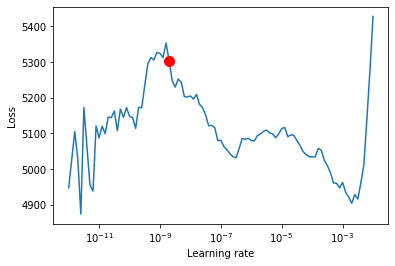

In [8]:
lr_finder = trainer.lr_find(vidcolornet, early_stop_threshold=None, min_lr=1e-11, max_lr=1e-2)
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr)

In [8]:
trainer.fit(vidcolornet)


  | Name               | Type           | Params
--------------------------------------------------
0 | encoder            | ResNet_encoder | 23 M  
1 | concat             | Concat         | 18 M  
2 | sourcerefattention | Attention      | 393 K 
3 | selfattention1     | Attention      | 393 K 
4 | decoder            | Decoder        | 6 M   
5 | tanh               | Tanh           | 0     
6 | f_loss             | SmoothL1Loss   | 0     


wandb: WARNING Adding to old History rows isn't currently supported.  Step 0 < 1; dropping {'lr-Adam': 1e-07}.
wandb: WARNING Adding to old History rows isn't currently supported.  Step 0 < 1; dropping {'epoch': 0}.


Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [7]:
torch.save(vidcolornet.state_dict(), "checkpoints/weights_fine_tune.pth")